###  K_nearest Neighbors Modelling

### Import relevant libaries and preprocessed dataset

In [36]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn import ensemble
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import neighbors

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from joblib import dump, load
from tabulate import tabulate

In [37]:
df = pd.read_csv('../../Data/processed/weatherAUS_imputed.csv')
df.head()

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


In [38]:
#Before starting the modelling process we will define a function to display the confusion matrix and classification_report 
def confusion_matrix_classification_report(test, pred_test, train, pred_train):
    #calculate confusion matrix 
    conf_matrix = confusion_matrix(test, pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale if needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(test, pred_test)

    # Print the classification report
    print('-------------------------')
    print(report)

    # Calculate accuracy for both sets
    print('-------------------------')
    train_accuracy = accuracy_score(train, pred_train)
    test_accuracy = accuracy_score(test, pred_test)
    print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

### K_nearest neighbors

### 1. Without over or undersampling 

In [39]:
data = df.drop(columns=['RainTomorrow','Location','Date'])
target = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### 1.1 Default KNN model with n_neighbors 5 and Minkowski

In [7]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(X_train,y_train)

KNeighborsClassifier()

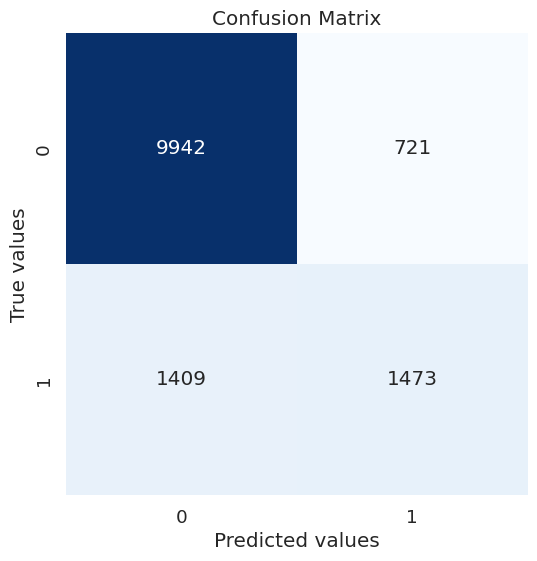

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     10663
         1.0       0.67      0.51      0.58      2882

    accuracy                           0.84     13545
   macro avg       0.77      0.72      0.74     13545
weighted avg       0.83      0.84      0.83     13545

-------------------------
Accuracy Train Set: 0.889 Accuracy Test Set: 0.843


In [23]:
y_pred_mi = knn.predict(X_test)
y_pred_train_mi = knn.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_mi, y_train, y_pred_train_mi)

### 1.2 GridSearch 

In [15]:
knn_model = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 41), 'metric': ['minkowski','manhattan','chebyshev']}
nfolds = 5

In [17]:
grid_knn = GridSearchCV(knn_model, param_grid, cv=nfolds)

In [18]:
knn_fit = grid_knn.fit(X_train, y_train)

In [34]:
dump(knn_fit, 'knn_fit.joblib')

{'metric': 'manhattan', 'n_neighbors': 23}

In [2]:
knn_fit = load('knn_fit.joblib')
knn_fit.best_params_

{'metric': 'manhattan', 'n_neighbors': 23}

### 1.3 Model with best parameters 

In [38]:
# best parameters {'metric': 'manhattan', 'n_neighbors': 23}
knn_best = neighbors.KNeighborsClassifier(n_neighbors=23, metric="manhattan")
knn_best.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

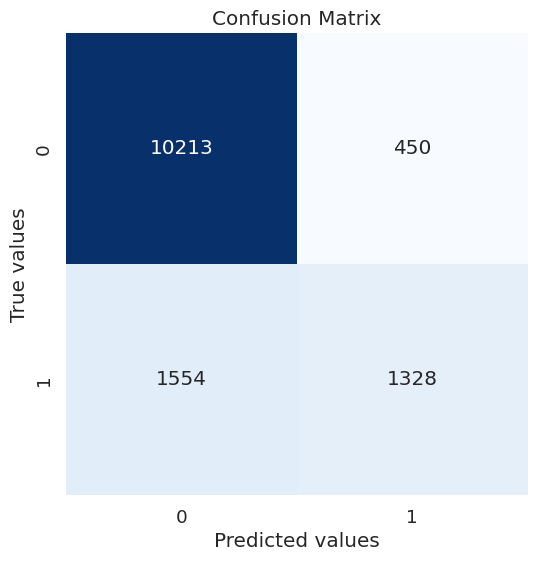

-------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     10663
         1.0       0.75      0.46      0.57      2882

    accuracy                           0.85     13545
   macro avg       0.81      0.71      0.74     13545
weighted avg       0.84      0.85      0.84     13545

-------------------------
Accuracy Train Set: 0.863 Accuracy Test Set: 0.852


In [40]:
y_pred_best = knn_best.predict(X_test)
y_pred_train_best = knn_best.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_best, y_train, y_pred_train_best)

### 2. With over sampling 

### 2.1 RandomOverSampling

In [40]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train,y_train)

In [41]:
knn_ros = neighbors.KNeighborsClassifier(n_neighbors=23, metric="manhattan")
knn_ros.fit(X_ros, y_ros)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

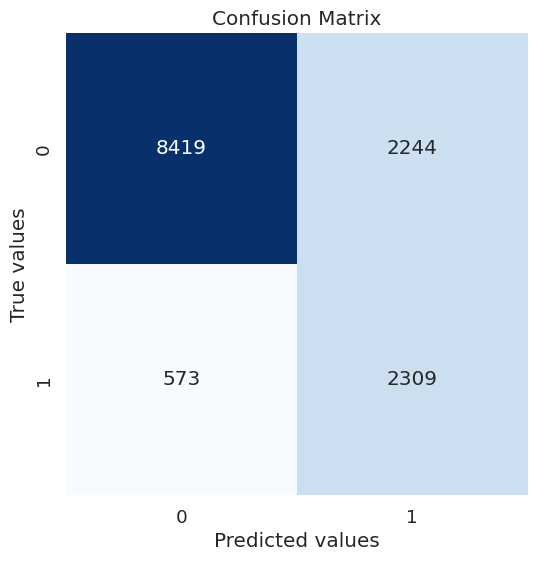

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86     10663
         1.0       0.51      0.80      0.62      2882

    accuracy                           0.79     13545
   macro avg       0.72      0.80      0.74     13545
weighted avg       0.84      0.79      0.81     13545

-------------------------
Accuracy Train Set: 0.816 Accuracy Test Set: 0.792


In [42]:
y_pred_ros = knn_ros.predict(X_test)
y_pred_train_ros = knn_ros.predict(X_train)

confusion_matrix_classification_report(y_test, y_pred_ros, y_train, y_pred_train_ros)

In [43]:
dump(y_pred_ros, 'y_pred_ros_knn.joblib')
dump(y_pred_train_ros, 'y_pred_train_ros_knn.joblib')

['y_pred_train_ros_knn.joblib']

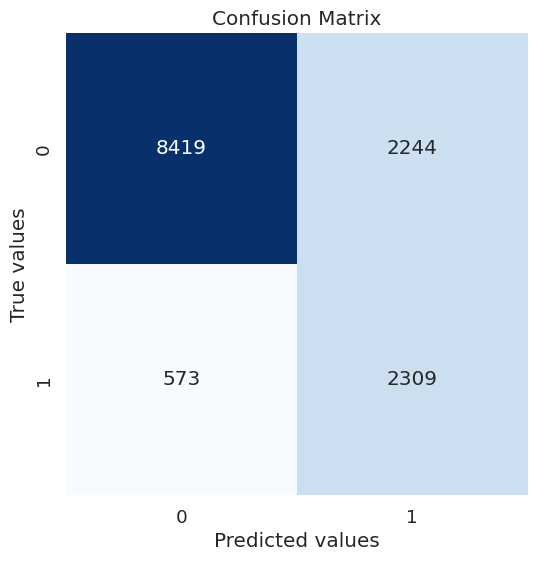

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86     10663
         1.0       0.51      0.80      0.62      2882

    accuracy                           0.79     13545
   macro avg       0.72      0.80      0.74     13545
weighted avg       0.84      0.79      0.81     13545

-------------------------
Accuracy Train Set: 0.816 Accuracy Test Set: 0.792


In [44]:
y_pred_ros_knn = load('y_pred_ros_knn.joblib')
y_pred_train_ros_knn = load('y_pred_train_ros_knn.joblib')
confusion_matrix_classification_report(y_test, y_pred_ros_knn, y_train, y_pred_train_ros_knn)

### 2.2 SMOTE

In [18]:
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train,y_train)

In [19]:
knn_sm = neighbors.KNeighborsClassifier(n_neighbors=23, metric="manhattan")
knn_sm.fit(X_sm, y_sm)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

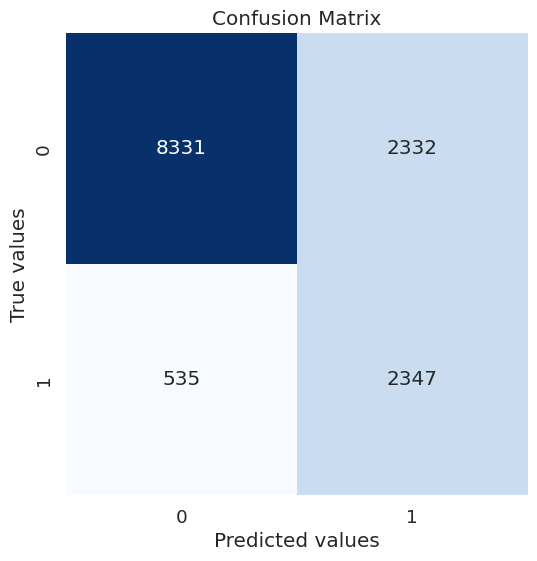

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85     10663
         1.0       0.50      0.81      0.62      2882

    accuracy                           0.79     13545
   macro avg       0.72      0.80      0.74     13545
weighted avg       0.85      0.79      0.80     13545

-------------------------
Accuracy Train Set: 0.813 Accuracy Test Set: 0.788


In [20]:
y_pred_sm = knn_sm.predict(X_test)
y_pred_train_sm = knn_sm.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_sm, y_train, y_pred_train_sm)

In [21]:
dump(y_pred_sm, 'y_pred_sm_knn.joblib')
dump(y_pred_train_sm, 'y_pred_train_sm_knn.joblib')

['y_pred_train_sm_knn.joblib']

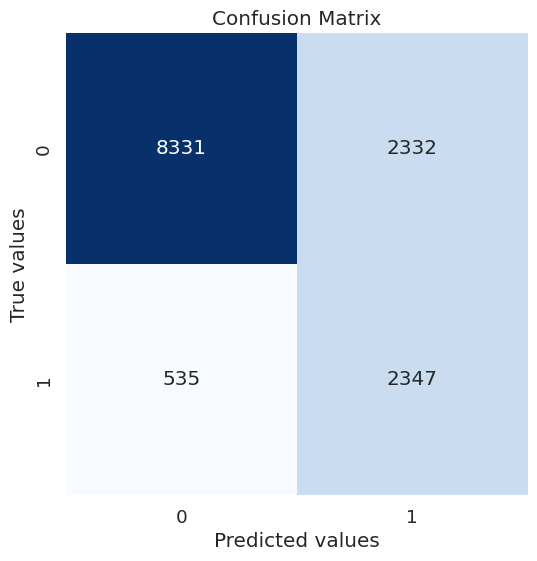

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85     10663
         1.0       0.50      0.81      0.62      2882

    accuracy                           0.79     13545
   macro avg       0.72      0.80      0.74     13545
weighted avg       0.85      0.79      0.80     13545

-------------------------
Accuracy Train Set: 0.813 Accuracy Test Set: 0.788


In [22]:
y_pred_sm_knn = load('y_pred_sm_knn.joblib')
y_pred_train_sm_knn = load('y_pred_train_sm_knn.joblib')
confusion_matrix_classification_report(y_test, y_pred_sm_knn, y_train, y_pred_train_sm_knn)

### 3. With undersampling 

### 3.1 RandomUnderSampler

In [23]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(data,target)

In [24]:
knn_rus = neighbors.KNeighborsClassifier(n_neighbors=23, metric="manhattan")
knn_rus.fit(X_rus, y_rus)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

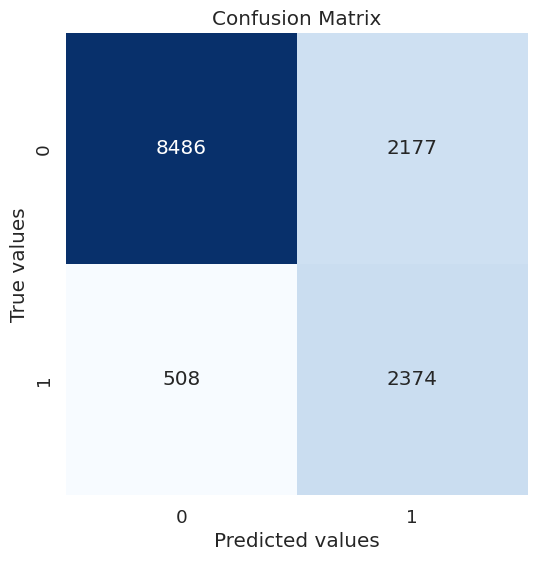

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.86     10663
         1.0       0.52      0.82      0.64      2882

    accuracy                           0.80     13545
   macro avg       0.73      0.81      0.75     13545
weighted avg       0.85      0.80      0.82     13545

-------------------------
Accuracy Train Set: 0.804 Accuracy Test Set: 0.802


In [25]:
y_pred_rus = knn_rus.predict(X_test)
y_pred_train_rus = knn_rus.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_rus, y_train, y_pred_train_rus)

In [26]:
dump(y_pred_rus, 'y_pred_rus_knn.joblib')
dump(y_pred_train_rus, 'y_pred_train_rus_knn.joblib')

['y_pred_train_rus_knn.joblib']

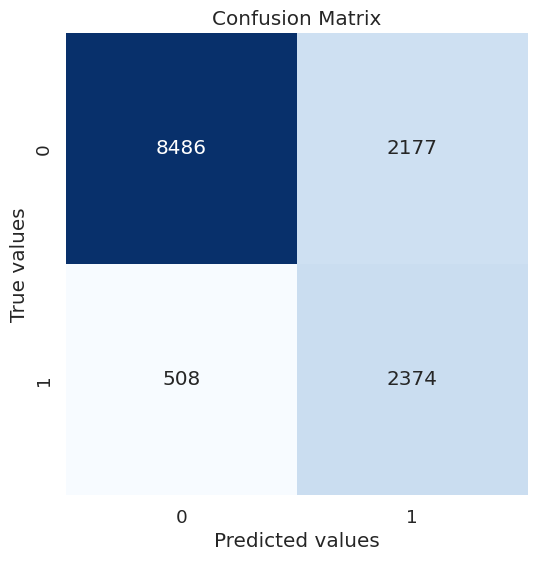

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.86     10663
         1.0       0.52      0.82      0.64      2882

    accuracy                           0.80     13545
   macro avg       0.73      0.81      0.75     13545
weighted avg       0.85      0.80      0.82     13545

-------------------------
Accuracy Train Set: 0.804 Accuracy Test Set: 0.802


In [27]:
y_pred_rus_knn = load('y_pred_rus_knn.joblib')
y_pred_train_rus_knn = load('y_pred_train_rus_knn.joblib')
confusion_matrix_classification_report(y_test, y_pred_rus_knn, y_train, y_pred_train_rus_knn)

### 4. Conclusion Over/Undersampling

Undersampling seems to have the best accuracy. The recall score for class 1 greatly improved with random under sampling. But the prediction score is quite low with only 0.52.

Let's see if we can improve the scores with some hyperparameter tuning. 

### 5.  Hyperparameter tuning with Random Undersampling

### 5.1 GridSearchCV

In [45]:
knn_model = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 30), 'metric': ['manhattan']}
nfolds = 5

In [46]:
grid_knn_rus = GridSearchCV(knn_model, param_grid, cv=nfolds)
knn_fit_rus = grid_knn_sm.fit(X_rus, y_rus)

In [47]:
dump(knn_fit_rus, 'knn_fit_rus.joblib')

['knn_fit_rus.joblib']

In [48]:
knn_fit_rus = load('knn_fit_sm.joblib')
knn_fit_rus.best_params_

{'metric': 'manhattan', 'n_neighbors': 2}

### 5.2 Best Parameters Fit

In [32]:
knn_rus_best = neighbors.KNeighborsClassifier(n_neighbors=1, metric="manhattan")
knn_rus_best.fit(X_rus, y_rus)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

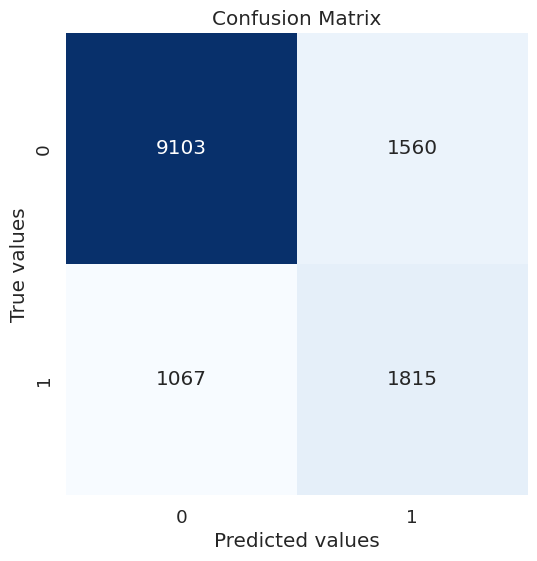

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87     10663
         1.0       0.54      0.63      0.58      2882

    accuracy                           0.81     13545
   macro avg       0.72      0.74      0.73     13545
weighted avg       0.82      0.81      0.81     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.806


In [33]:
y_pred_best = knn_rus_best.predict(X_test)
y_pred_train_best = knn_rus_best.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_best, y_train, y_pred_train_best)

### 7. Cross Validation 

In [49]:
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

cv_results = cross_validate(knn_rus, X_train, y_train, cv=10, return_estimator=True, scoring=scoring)

In [50]:
fold_numbers = range(1,11)
test_precision = cv_results['test_precision']
test_recall = cv_results['test_recall']
test_f1_score = cv_results['test_f1_score']
table = [["Fold", "Test Precision", "Test Recall", "Test F1-Score"]]
for fold, prec, recall, f1 in zip(fold_numbers, test_precision, test_recall, test_f1_score):
    table.append([fold, f"{prec:.3f}", f"{recall:.3f}", f"{f1:.3f}"])

# Print table
print(tabulate(table, headers="firstrow", tablefmt="pretty"))

+------+----------------+-------------+---------------+
| Fold | Test Precision | Test Recall | Test F1-Score |
+------+----------------+-------------+---------------+
|  1   |     0.853      |    0.861    |     0.848     |
|  2   |     0.843      |    0.852    |     0.836     |
|  3   |     0.838      |    0.848    |     0.831     |
|  4   |     0.838      |    0.849    |     0.835     |
|  5   |     0.850      |    0.857    |     0.843     |
|  6   |     0.836      |    0.847    |     0.834     |
|  7   |     0.842      |    0.852    |     0.838     |
|  8   |     0.841      |    0.850    |     0.836     |
|  9   |     0.840      |    0.850    |     0.837     |
|  10  |     0.845      |    0.854    |     0.840     |
+------+----------------+-------------+---------------+


### 8. Conclusion 